In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math
import pygsp
import networkx as nx
import param

In [2]:
Number_Of_Nodes = 10
Number_Of_Generators = 3
W = np.random.rand(Number_Of_Nodes,Number_Of_Nodes) + np.random.rand(Number_Of_Nodes,Number_Of_Nodes)*1j
W_Symm = (W + W.T)/2
for i in range(Number_Of_Nodes):
    W_Symm[i,i] = 0
W_Diagonal = -np.sum(W_Symm,1)
for i in range(Number_Of_Nodes):
    W_Symm[i,i] = W_Diagonal[i]

2022-12-01 11:03:45,958:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
c:\ProgramData\Anaconda3\lib\site-packages\pygsp\plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)


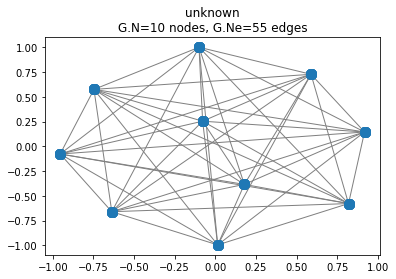

In [3]:
G = pygsp.graphs.Graph(W_Symm)
G.set_coordinates()
plt.Figure
pygsp.plotting.plot_graph(G);

c:\ProgramData\Anaconda3\lib\site-packages\pygsp\plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)


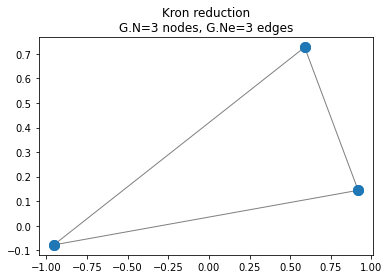

In [4]:
ind = list(range(1,Number_Of_Generators+1,1))
Gnew = pygsp.reduction.kron_reduction( G,ind );
plt.Figure
pygsp.plotting.plot_graph(Gnew);

In [5]:
Y_ij_EN = np.zeros((Number_Of_Generators,Number_Of_Generators)) + np.zeros((Number_Of_Generators,Number_Of_Generators))*1j
Y_ij = np.array(pygsp.graphs.Graph.get_edge_list(Gnew))
Index_1 = Y_ij[0,:].astype(int)
Index_2 = Y_ij[1,:].astype(int)
Weights = Y_ij[2,:]
for i in range(len(Weights)):
    Y_ij_EN[Index_1[i]][Index_2[i]] = Weights[i]
    Y_ij_EN[Index_2[i]][Index_1[i]] = Weights[i]

<ipython-input-5-4451968f2832>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  Index_1 = Y_ij[0,:].astype(int)
<ipython-input-5-4451968f2832>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  Index_2 = Y_ij[1,:].astype(int)


In [6]:
Y_ij_mag = np.absolute(Y_ij_EN)
Y_ij_angle = np.angle(Y_ij_EN)
gamma_ik = np.array([x - (math.pi)/2 for x in Y_ij_angle])

Setting the parameters for the generators

In [7]:
Order_Of_Real_Power_Generation = 100
Order_Of_Reactive_Power_Generation = 50
Order_Of_Beta = 50
Order_xd = 0.150
P_G = Order_Of_Real_Power_Generation*np.random.rand(Number_Of_Generators,1)
Q_G = Order_Of_Reactive_Power_Generation*np.random.rand(Number_Of_Generators,1)
Beta = Order_Of_Beta*np.random.rand(Number_Of_Generators,1)
xd = Order_xd*np.random.rand(Number_Of_Generators,1)
V = np.ones((Number_Of_Generators,1))

Calculating the internal voltage magnitude

In [8]:
E = np.zeros((Number_Of_Generators,1))
for i in range(Number_Of_Generators):
    E[i] = math.sqrt(((P_G[i]*xd[i])/V[i])**2 + (V[i] + (Q_G[i]*xd[i])/V[i])**2)

Calculating the net power output

In [9]:
A = np.zeros((Number_Of_Generators,1))
for i in range(Number_Of_Generators):
    A[i] = P_G[i] - (E[i]**2)*(Y_ij_mag[i][i])

Calculating the phase angle shift

In [10]:
c_ik = np.zeros((Number_Of_Generators,Number_Of_Generators))
for i in range(Number_Of_Generators):
    for j in range(Number_Of_Generators):
        c_ik[i][j] = E[i]*E[j]*Y_ij_mag[i][j]

Solving the ordinary differential equations

In [11]:
intial_state = [0, 0, 0, 0, 0, 0]
time_points = np.linspace(0, 10, 1000)

In [12]:
def my_system(current_state, t):
    theta1, theta2, theta3, omega1, omega2, omega3 = current_state

    dtheta1_dt = omega1
    dtheta2_dt = omega2
    dtheta3_dt = omega3
    d2theta1_dt2 = -Beta[0]*omega1 + A[0] - c_ik[0][1]*math.sin(theta1 - theta2 - gamma_ik[0][1]) - c_ik[0][2]*math.sin(theta1 - theta3 - gamma_ik[0][2])
    d2theta2_dt2 = -Beta[1]*omega2 + A[1] - c_ik[1][0]*math.sin(theta2 - theta1 - gamma_ik[1][0]) - c_ik[1][2]*math.sin(theta2 - theta3 - gamma_ik[1][2])
    d2theta3_dt2 = -Beta[2]*omega3 + A[2] - c_ik[2][0]*math.sin(theta3 - theta1 - gamma_ik[2][0]) - c_ik[2][1]*math.sin(theta3 - theta2 - gamma_ik[2][1])
    return [omega1, omega2, omega3, d2theta1_dt2, d2theta2_dt2, d2theta3_dt2]

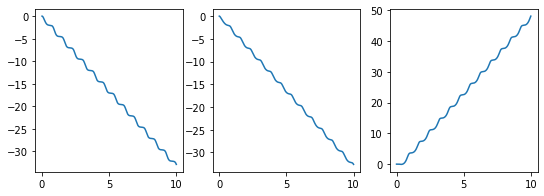

In [13]:
Phase_Angles = odeint(my_system, intial_state, time_points)

Phase_Angle_1 = Phase_Angles[:,0]
Phase_Angle_2 = Phase_Angles[:,1]
Phase_Angle_3 = Phase_Angles[:,2]

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.plot(time_points, Phase_Angle_1)
plt.subplot(132)
plt.plot(time_points, Phase_Angle_2)
plt.subplot(133)
plt.plot(time_points, Phase_Angle_3)
plt.show()